<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
titanic = pd.read_csv('../../../DATA/titanic_train.csv', index_col='PassengerId')

Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

In [3]:
# Shape
titanic.shape

(891, 11)

In [4]:
# Head
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
# Check how many data are missing in these columns
titanic.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
def facetgridplot(train, var):
    facet = sns.FacetGrid(train, hue="Survived", aspect=4)
    facet.map(sns.kdeplot, var, shade= True)
    facet.set(xlim=(0, train[var].max()))
    facet.add_legend()
    plt.show();

In [7]:
def bar_chart(train, feature):
    survived = train[train['Survived']==1][feature].value_counts(normalize=True)*100
    dead = train[train['Survived']==0][feature].value_counts(normalize=True)*100
    df = pd.DataFrame([survived,dead])
    df.index = ['Survived','Dead']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

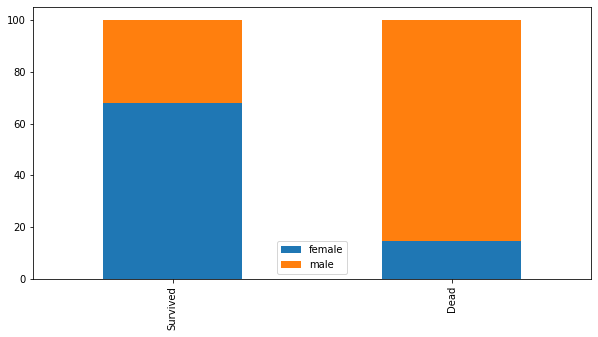

In [8]:
# Sex
bar_chart(titanic, 'Sex')

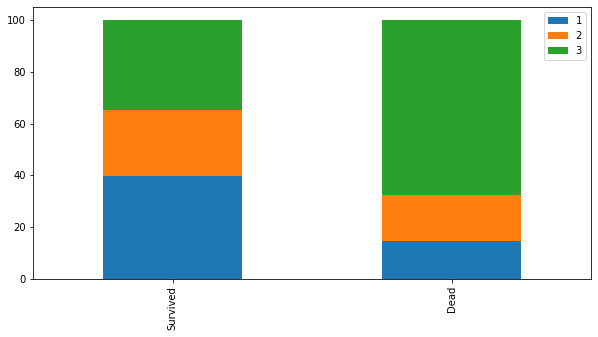

In [9]:
# Pclass
bar_chart(titanic, 'Pclass')

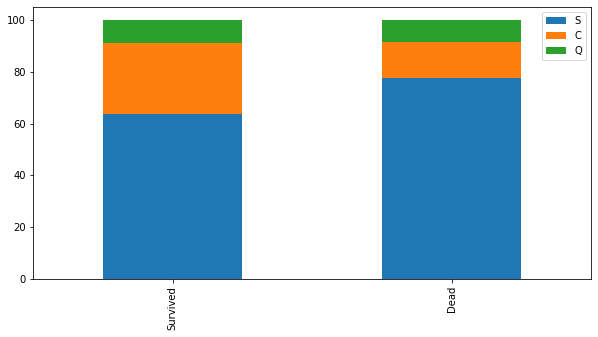

In [10]:
# Embarked
bar_chart(titanic, 'Embarked')

In [11]:
# Find median age by sex

titanic.groupby("Sex")["Age"].median()

Sex
female    27.0
male      29.0
Name: Age, dtype: float64

In [12]:
# The following is an array of the median age by sex
titanic.groupby("Sex")["Age"].transform("median")

PassengerId
1      29.0
2      27.0
3      27.0
4      27.0
5      29.0
       ... 
887    29.0
888    27.0
889    27.0
890    29.0
891    29.0
Name: Age, Length: 891, dtype: float64

In [13]:
# fill missing age with median age for each sex (0 (male), 1 (female)) in new column
titanic["Age_imp"] = titanic["Age"].fillna(titanic.groupby("Sex")["Age"].transform("median"))

# check values
titanic[titanic['Age'].isnull()][['Sex', 'Age', 'Age_imp']].head(10)

,Sex,Age,Age_imp
PassengerId,,,
6,male,NaN,29.0
18,male,NaN,29.0
20,female,NaN,27.0
27,male,NaN,29.0
29,female,NaN,27.0
30,male,NaN,29.0
32,female,NaN,27.0
33,female,NaN,27.0
37,male,NaN,29.0


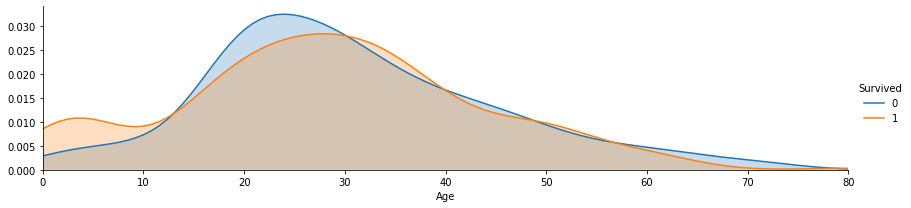

In [14]:
# Age
facetgridplot(titanic, 'Age')

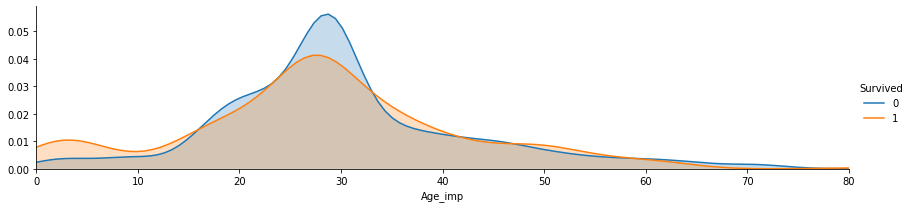

In [15]:
# Age
facetgridplot(titanic, 'Age_imp')

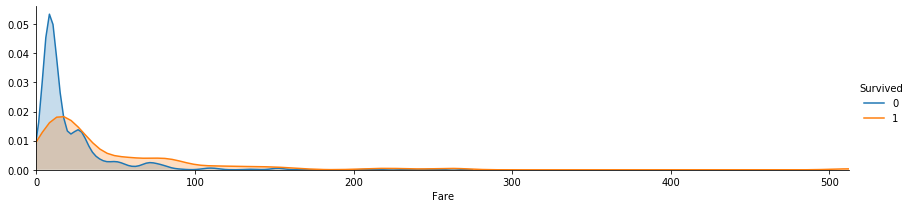

In [16]:
# Fare
facetgridplot(titanic, 'Fare')

In [17]:
# fill missing embarked with `S` as most people embarked from there
titanic['Embarked'].fillna('S', inplace=True)

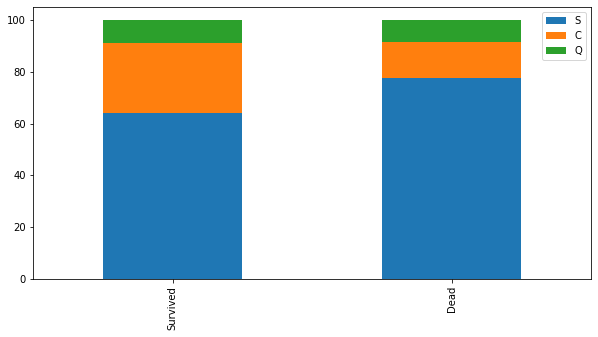

In [18]:
bar_chart(titanic, 'Embarked')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class and parents/children features:

In [117]:
# ANSWER
feature_cols = ['Pclass', 'Parch']
X = titanic[feature_cols]
y = titanic['Survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

In [118]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [119]:
# ANSWER
# Create Model
logreg = LogisticRegression(solver='liblinear', max_iter=10000)

Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [120]:
# ANSWER
# Fit Model
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

The computed coefficients are an array stored in the 1st element of an array:

In [121]:
# ANSWER
logreg.coef_

array([[-0.84439049,  0.3412417 ]])

The computed intercept is the 1st element of another array:

In [89]:
# ANSWER
logreg.intercept_

array([1.23165951])

We can create tuples of the predictor names and coefficients like this:

In [90]:
# ANSWER
print(set(zip(feature_cols, logreg.coef_[0])))

{('Parch', 0.3412416997316228), ('Pclass', -0.8443904940738124)}


In [91]:
pd.DataFrame({'feature': feature_cols, 'coefficient': logreg.coef_[0]})

,feature,coefficient
0,Pclass,-0.844390
1,Parch,0.341242


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [92]:
for col in zip(X_train.columns, logreg.coef_[0]):
    print('{:<10s}  {:+.06f}'.format(col[0], col[1]))  # Nb. increase 10 for longer names

Pclass      -0.844390
Parch       +0.341242


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [93]:
print('accuracy = {:7.4f}'.format(logreg.score(X_train, y_train)))

accuracy =  0.6901


What is the  `accuracy_score` for the test data?

In [94]:
#?
print('accuracy = {:7.4f}'.format(logreg.score(X_test, y_test)))

accuracy =  0.6682


What can we say aout this result?

ANSWER
- test set is predicted almost as well as training set
- overfitting seems unlikely

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [95]:
# ANSWER
titanic['Age'].fillna(titanic.Age.mean(), inplace=True)
feature_cols = ['Pclass', 'Parch', 'Age']
X = titanic[feature_cols]

In [96]:
# Build Model
logreg = LogisticRegression(solver='liblinear', max_iter=10000)

# Fit Model
logreg.fit(X_train, y_train)

# Score
logreg_score = logreg.score(X_train, y_train)
print('accuracy = {:1.4f}'.format(logreg_score))

accuracy = 0.6901


In [122]:
logreg_score = logreg.score(X_test, y_test)
print('accuracy = {:1.4f}'.format(logreg_score))

accuracy = 0.6682


In [123]:
titanic.Age.mean()

29.699117647058763

In [124]:
titanic.groupby('Sex')['Age'].mean()

Sex
female    28.216730
male      30.505824
Name: Age, dtype: float64

So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- age is not related to Titanic survival
- age is not independent of other features already in the model
- imputing the missing values distorted the distribution too much

Let's see where the model is going wrong by showing the Confusion Matrix:

In [125]:
y_pred_class = logreg.predict(X_test)
print(metrics.confusion_matrix(y_test, y_pred_class))

[[105  23]
 [ 51  44]]


Nb. Here is how `confusion_matrix` arranges its output:

In [98]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


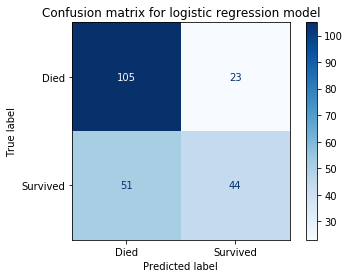

In [99]:
# Plot confusion matrix
metrics.plot_confusion_matrix(logreg, X_test, y_test,
                              display_labels=['Died', 'Survived'],
                              cmap=plt.cm.Blues,
                              values_format='d')
plt.title('Confusion matrix for logistic regression model')
plt.show()

Which type of error is more prevalent?

ANSWER:Type 2 (false negatives).

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

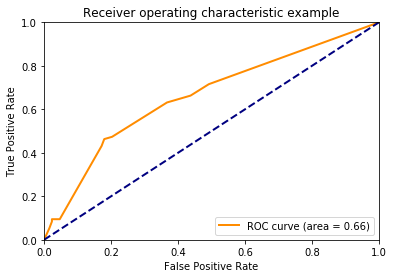

In [100]:
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = metrics.roc_curve(y_test, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = metrics.auc(fpr, tpr)

# Plot the ROC Curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [101]:
titanic_with_dummies = pd.get_dummies(data = titanic, columns = ['Sex', 'Embarked', 'Pclass'], 
                                      prefix = ['Sex', 'Embarked', 'Pclass'] )
titanic_with_dummies.head()

,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Age_imp,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,22.0,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,38.0,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,26.0,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,35.0,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,35.0,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [147]:
# Calculate mean age by parch, sex, passenger class

titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].mean()

Parch  Sex_male  Pclass_1  Pclass_2
0      0         0         0           26.090266
                           1           31.953294
                 1         0           35.462390
       1         0         0           29.073054
                           1           33.233619
                 1         0           39.789712
1      0         0         0           18.051859
                           1           24.666667
                 1         0           38.276419
       1         0         0           16.917245
                           1           18.107143
                 1         0           44.071429
2      0         0         0           18.035753
                           1           20.454545
                 1         0           22.230769
       1         0         0           16.110866
                           1           19.866000
                 1         0           21.615000
3      0         0         0           36.000000
                           1     

So the mean age for female 3rd class passengers with no parents or children on board is 26.090266, female 2nd class passengers with no parents or children on board have a mean age of 31.953294, female 1st class passengers with no parents or children on board have a mean age of 35.462390, etc. 

In [128]:
# Impute age

titanic_with_dummies['Age'] = titanic_with_dummies[["Age", "Parch", "Sex_male", "Pclass_1", "Pclass_2"]].groupby(["Parch", "Sex_male", "Pclass_1", "Pclass_2"])["Age"].transform(lambda x: x.fillna(x.mean()))

Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [129]:
def get_logreg_score(data, feature_cols, target_col):
    X = data[feature_cols]
    y = data[target_col]

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

    # Build Model
    logreg = LogisticRegression(solver='liblinear', max_iter=10000)

    # Fit
    logreg.fit(X_train, y_train)

    # Score
    logreg_score = logreg.score(X_test, y_test)

    # Return accuracy rate
    return logreg_score

In [130]:
# ANSWER
# Set Feature Both Numerical, Categorical
target_col = 'Survived'
feature_cols = ['Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Age', 'SibSp']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

0.6502242152466368

Plot the ROC curve for the new model:

In [131]:
# ANSWER
def plot_roc_curve(X_test, y_test):
    # Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
    preds = logreg.predict_proba(X_test)[:,1]

    # Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
    fpr, tpr, _ = metrics.roc_curve(y_test, preds)

    # Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
    roc_auc = metrics.auc(fpr, tpr)

    # Plot the ROC Curve
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc = "lower right")
    plt.show()

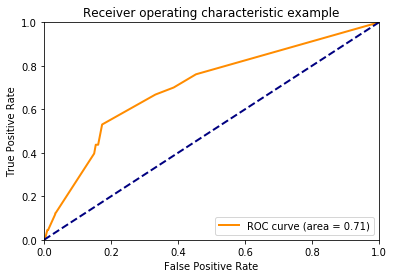

In [132]:
# Train
plot_roc_curve(X_train, y_train)

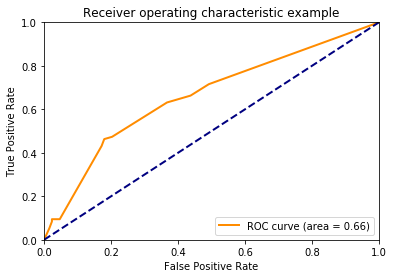

In [133]:
# Test
plot_roc_curve(X_test, y_test)

Can we improve the model by including the remaining features?

In [134]:
# ANSWER 
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
get_logreg_score(titanic_with_dummies, feature_cols, target_col)

0.7982062780269058

In [135]:
ttwd = titanic_with_dummies
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                            100 * ttwd[ttwd.Sex_male == 1].Survived.mean(), ttwd.Sex_male.sum(), 
                                            100 * ttwd[ttwd.Sex_female == 1].Survived.mean(), ttwd.Sex_female.sum(),
                                            100 * ttwd[ttwd.Age < 16].Survived.mean(), len(ttwd[ttwd.Age < 16])))

Male survival: 18.89% of 577
Female survival: 74.20% of 314
Child survival: 59.04% of 83


In [136]:
X = titanic_with_dummies[feature_cols]
y = titanic_with_dummies[target_col]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

# Build Model
logreg = LogisticRegression(solver='liblinear', max_iter=10000)

# Fit
logreg.fit(X_train, y_train)

# Make a data frame of results, including actual and predicted response:
y_hat = logreg.predict(X)
y_hats = pd.Series(y_hat, index = X.index)
y_hatdf = pd.DataFrame({'y_hat': y_hats})
y_actuals = pd.Series(y, index = X.index)    # names 'y', 'y_test' are in use
y_actualdf = pd.DataFrame({'y_actual': y_actuals})   
ttall = y_hatdf.join(y_actualdf).join(X)
ttall.head()

,y_hat,y_actual,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
PassengerId,,,,,,,,,,,,,,
1,0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
2,1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
3,1,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
4,1,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
5,0,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


In [137]:
print("Male survival: {:5.2f}% of {}\nFemale survival: {:5.2f}% of {}\nChild survival: {:5.2f}% of {}".format(
                                                    100 * ttall[ttall.Sex_male == 1].y_hat.mean(), ttall.Sex_male.sum(), 
                                                    100 * ttall[ttall.Sex_female == 1].y_hat.mean(), ttall.Sex_female.sum(),
                                                    100 * ttall[ttall.Age < 16].y_hat.mean(), len(ttall[ttall.Age < 16])))

Male survival:  5.55% of 577
Female survival: 87.26% of 314
Child survival: 51.81% of 83


##### Why use `random_state` when splitting data?

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
X_train.index

Int64Index([ 36,  47, 454, 292, 749,  42, 225, 341, 126, 804,
            ...
            584, 130, 145, 848, 646, 716, 768,  73, 236,  38],
           dtype='int64', name='PassengerId', length=668)

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.index

Int64Index([638, 154, 440, 375, 794, 389,  89, 394, 239, 304,
            ...
            683, 331, 871, 361,  56,  31, 403, 365, 135, 666],
           dtype='int64', name='PassengerId', length=668)

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_train.index

Int64Index([262, 200, 573, 732, 277, 843, 881, 467, 454, 681,
            ...
            863, 759, 192, 255, 344, 795, 165, 482,  55,  86],
           dtype='int64', name='PassengerId', length=668)

## Homework

1. Remove the `random_state` parameter, so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

#### 2. Use Cross-Validation

Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

In [80]:
from sklearn.model_selection import cross_val_score
target_col = 'Survived'
feature_cols = ['Age', 'SibSp', 'Parch', 'Fare', 
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'Pclass_1', 'Pclass_2', 'Pclass_3']
logreg = LogisticRegression()
scores = cross_val_score(logreg, titanic_with_dummies[feature_cols], titanic_with_dummies[target_col], cv=5)
scores.mean()

C:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\conda\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOG

0.80248571966606

#### 3. Look at the fpr & tpr vectors for the best model.

In [0]:
# Build Model
logreg = LogisticRegression()

# Fit
logreg.fit(X_train, y_train)

# Predict
y_pred_class = logreg.predict(X_test)

# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(y_test, y_pred_class)
print(confusion)

#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[105  23]
 [ 51  44]]


**Classification Accuracy:** Overall, how often is the classifier correct?

In [0]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(y_test, y_pred_class))

0.6681614349775785
0.6681614349775785


**Classification Error:** Overall, how often is the classifier incorrect?

Also known as "Misclassification Rate"

In [0]:
classification_error = (FP + FN) / float(TP + TN + FP + FN)
print(classification_error)
print(1 - metrics.accuracy_score(y_test, y_pred_class))

0.33183856502242154
0.3318385650224215


**Sensitivity:** When the actual value is positive, how often is the prediction correct?

Something we want to maximize
How "sensitive" is the classifier to detecting positive instances?
- Also known as "True Positive Rate" or "Recall"
- TP / all positive
    - all positive = TP + FN

In [0]:
sensitivity = TP / float(FN + TP)
print(sensitivity)
print(metrics.recall_score(y_test, y_pred_class))

0.4631578947368421
0.4631578947368421


**Specificity:** When the actual value is negative, how often is the prediction correct?

Something we want to maximize
How "specific" (or "selective") is the classifier in predicting positive instances?
TN / all negative
all negative = TN + FP

In [0]:
specificity = TN / (TN + FP)

print(specificity)

0.8203125


**False Positive Rate:** When the actual value is negative, how often is the prediction incorrect?

In [0]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.1796875
0.1796875


**Precision:** When a positive value is predicted, how often is the prediction correct?

How "precise" is the classifier when predicting positive instances?

In [0]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(y_test, y_pred_class))

0.6567164179104478
0.6567164179104478




---



---



> > > > > > > > > © 2021 Institute of Data


---



---



